# Time Series Similarity Search with aeon

The goal of Time Series Similarity Search is to asses the similarities between a time
 series, denoted as a query `q` of length `l`, and a collection of time series,
 denoted as `X`, with lengths greater than or equal to `l`. In this
 context, the notion of similiarity between `q` and the other series in `X` is quantified by similarity functions. Those functions are most of the time defined as distance function, such as the Euclidean distance. Knowing the similarity between `q` and other admissible candidates, we can then perform many other tasks for "free", such as anomaly or motif detection.

<img src="img/sim_search.png" width="600" alt="time series similarity search">

In [1]:
def plot_best_matches(top_k_search, best_matches):
    """Plot the top best matches of a query in a dataset."""
    fig, ax = plt.subplots(figsize=(20, 5), ncols=3)
    for i_k, (id_sample, id_timestamp) in enumerate(best_matches):
        # plot the sample of the best match
        ax[i_k].plot(top_k_search.X_[id_sample, 0], linewidth=2)
        # plot the location of the best match on it
        ax[i_k].plot(
            range(id_timestamp, id_timestamp + q.shape[1]),
            top_k_search.X_[id_sample, 0, id_timestamp : id_timestamp + q.shape[1]],
            linewidth=7,
            alpha=0.5,
            color="green",
            label="best match location",
        )
        # plot the query on the location of the best match
        ax[i_k].plot(
            range(id_timestamp, id_timestamp + q.shape[1]),
            q[0],
            linewidth=5,
            alpha=0.5,
            color="red",
            label="query",
        )
        ax[i_k].set_title(f"best match {i_k}")
        ax[i_k].legend()
    plt.show()


def plot_matrix_profile(X, mp, i_k):
    """Plot the matrix profile and corresponding time series."""
    fig, ax = plt.subplots(figsize=(20, 10), nrows=2)
    ax[0].set_title("series X used to build the matrix profile")
    ax[0].plot(X[0])  # plot first channel only
    # This is necessary as mp is a list of arrays due to unequal length support
    # as it can have different number of matches for each step when
    # using threshold-based search.
    ax[1].plot([mp[i][i_k] for i in range(len(mp))])
    ax[1].set_title(f"Top {i_k+1} matrix profile of X")
    ax[1].set_ylabel(f"Dist to top {i_k+1} match")
    ax[1].set_xlabel("Starting index of the query in X")
    plt.show()

## Similarity search Notebooks

This notebook gives an overview of similarity search module and the available estimators. The following notebooks are avaiable to go more in depth with specific subject of similarity search in aeon:

- [Deep dive in the distance profiles](distance_profiles.ipynb)
- [Analysis of the speedups provided by similarity search module](code_speed.ipynb)

## Expected inputs and format
For both `QuerySearch` and `SeriesSearch`, the `fit` method expects a time series dataset of shape `(n_cases, n_channels, n_timepoints)`. This can be 3D numpy array or a list of 2D numpy arrays if `n_timepoints` varies between cases (i.e. unequal length dataset).

The `predict` method expects a 2D numpy array of shape `(n_channels, query_length)` for `QuerySearch`. In `SeriesSearch`, the predict methods also expects a 2D numpy array, but  of shape `(n_channels, n_timepoints)` (`n_timepoints` doesn't have to be the same as in fit) and a `query_length` parameter.

## Available estimators

All estimators of the similarity search module in aeon inherit from the `BaseSimilaritySearch` class, which requires the following arguments:
- `distance` : a string indicating which distance function to use as similarity function. By default this is `"euclidean"`, which means that the Euclidean distance is used.
- `normalise` : a boolean indicating whether this similarity function should be z-normalised. This means that the scale of the two series being compared will be ignored, and that, loosely speaking, we will only focus on their shape during the comparison. By default, this parameter is set `False`.

Another parameter, which has no effect on the output of the estimators, is a boolean named `store_distance_profile`, set to `False` by default. If set to `True`, the estimators will expose an attribute named `_distance_profile` after the `predict` function is called. This attribute will contain the computed distance profile for query given as input to the `predict` function.

To illustrate how to work with similarity search estimators in aeon, we will now present some example use cases.

### Query search

We will use the GunPoint dataset for this example, which can be loaded using the `load_classification` function.

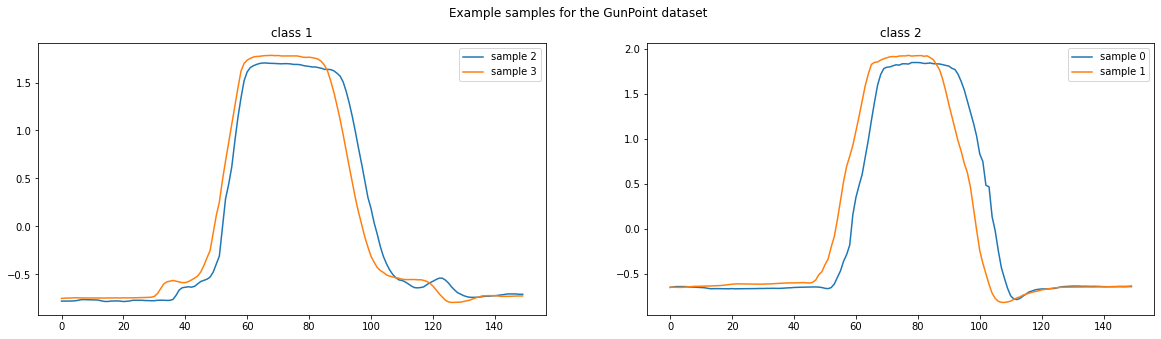

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from aeon.datasets import load_classification

# Load GunPoint dataset
X, y = load_classification("GunPoint")

classes = np.unique(y)

fig, ax = plt.subplots(figsize=(20, 5), ncols=len(classes))
for i_class, _class in enumerate(classes):
    for i_x in np.where(y == _class)[0][0:2]:
        ax[i_class].plot(X[i_x, 0], label=f"sample {i_x}")
    ax[i_class].legend()
    ax[i_class].set_title(f"class {_class}")
plt.suptitle("Example samples for the GunPoint dataset")
plt.show()

The GunPoint dataset is composed of two classes which are discriminated by the "bumps" located before and after the central peak. These bumps correspond to an actor drawing a fake gun from a holster before pointing it (hence the name "GunPoint" !). In the second class, the actor simply points his fingers without making the motion of taking the gun out of the holster.

Suppose that we define our input query for the similarity search task as one of these bumps:

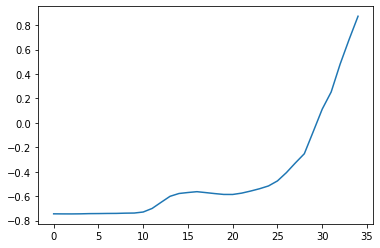

In [3]:
# We will use the fourth sample an testing data
X_test = X[3]
mask = np.ones(X.shape[0], dtype=bool)
mask[3] = False
# Use this mask to exluce the sample from which we will extract the query
X_train = X[mask]

q = X_test[:, 20:55]
plt.plot(q[0])
plt.show()

Then, we can use the `QuerySearch` class to search for the top `k` matches of this query in a collection of series. The training data for `QuerySearch` can be seen as the database in which want to search for the query on.

In [4]:
from aeon.similarity_search import QuerySearch

# Here, the distance function (distance and normalise arguments)
top_k_search = QuerySearch(k=3, distance="euclidean")
# Call fit to store X_train as the database to search in
top_k_search.fit(X_train)
distances_to_matches, best_matches = top_k_search.predict(q)
for i in range(len(best_matches)):
    print(f"match {i} : {best_matches[i]} with distance {distances_to_matches[i]} to q")

match 0 : [195  26] with distance 0.1973741999473598 to q
match 1 : [92 23] with distance 0.20753669049486048 to q
match 2 : [154  22] with distance 0.21538593730366784 to q


The similarity search estimators return a list of size `k`, which contains a tuple containing the location of the best matches as `(id_sample, id_timestamp)`. We can then plot the results as:

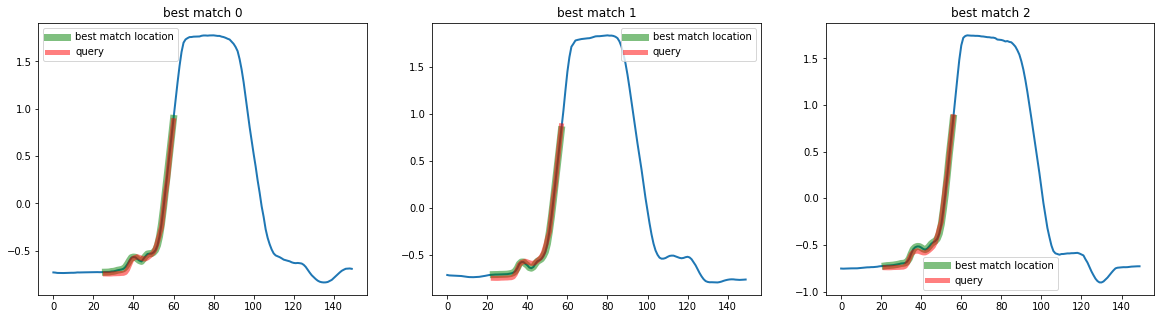

In [5]:
plot_best_matches(top_k_search, best_matches)

You may also want to search not for the top-k matches, but for all matches below a threshold on the distance from the query to a candidate. To do so, you can use the `threshold` parameter of `QuerySearch` :

In [6]:
# Here, the distance function (distance and normalise arguments)
top_k_search = QuerySearch(k=np.inf, threshold=0.25, distance="euclidean")
top_k_search.fit(X_train)
distances_to_matches, best_matches = top_k_search.predict(q)
for i in range(len(best_matches)):
    print(f"match {i} : {best_matches[i]} with distance {distances_to_matches[i]} to q")

match 0 : [195  26] with distance 0.1973741999473598 to q
match 1 : [92 23] with distance 0.20753669049486048 to q
match 2 : [154  22] with distance 0.21538593730366784 to q
match 3 : [176  25] with distance 0.21889484294879047 to q
match 4 : [23 20] with distance 0.22668346183441293 to q
match 5 : [167  23] with distance 0.24774491003815066 to q


C:\Users\antoine\Documents\aeon\aeon\similarity_search\query_search.py:270: UserWarning: Only 6 matches are bellow the threshold of 0.25, while k=inf. The number of returned match will be 6.
  return extract_top_k_and_threshold_from_distance_profiles(


You may also combine the `k` and `threshold` parameter :

In [7]:
# Here, the distance function (distance and normalise arguments)
top_k_search = QuerySearch(k=3, threshold=0.25, distance="euclidean")
top_k_search.fit(X_train)
distances_to_matches, best_matches = top_k_search.predict(q)
for i in range(len(best_matches)):
    print(f"match {i} : {best_matches[i]} with distance {distances_to_matches[i]} to q")

match 0 : [195  26] with distance 0.1973741999473598 to q
match 1 : [92 23] with distance 0.20753669049486048 to q
match 2 : [154  22] with distance 0.21538593730366784 to q


It is also possible to return the **worst** matches (not that the title of the plots are not accurate here) to the query, by using the `inverse_distance` parameter :

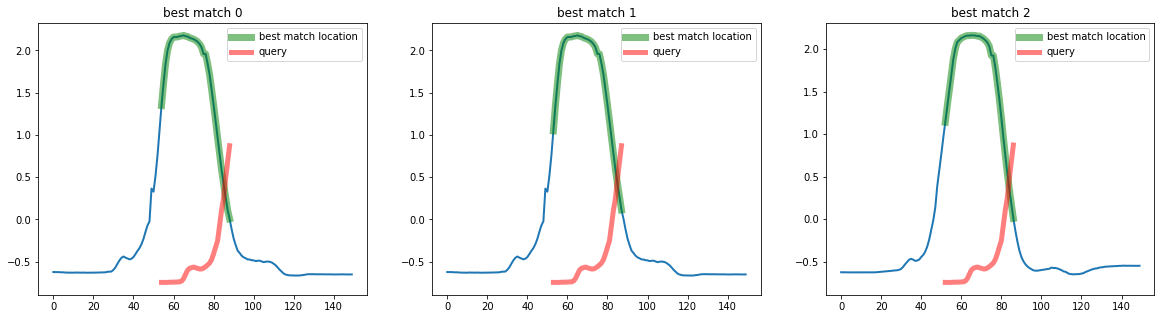

In [8]:
# Here, the distance function (distance and normalise arguments)
top_k_search = QuerySearch(k=3, inverse_distance=True, distance="euclidean")
top_k_search.fit(X_train)
distances_to_matches, best_matches = top_k_search.predict(q)
plot_best_matches(top_k_search, best_matches)

## Using the speed_up option for similarity search

In the similarity search module, we implement different kind of optimization to decrease the time necessary to extract the best matches to a query. You can find more information about these optimization in the other notebooks of the similarity search module. An utility function is available to list the optimizations currently implemented in aeon :

In [9]:
QuerySearch.get_speedup_function_names()

{'normalised euclidean': ['fastest', 'Mueen'],
 'euclidean': ['fastest', 'Mueen'],
 'normalised squared': ['fastest', 'Mueen'],
 'squared': ['fastest', 'Mueen']}

By default, the `fastest` option is used, which use the best optimisation available. You can change this behavior by using the values of t with the corresponding distance function and normalization options in the estimators, for example with a `QuerySearch` using the `normalised euclidean` distance:

In [10]:
top_k_search = QuerySearch(distance="euclidean", normalise=True, speed_up="Mueen")

For more information on these optimizations you can refer to the [distance profile notebook](distance_profiles.ipynb) for the theory, and to the [analysis of the speedups provided by similarity search module](code_speed.ipynb) for a comparison of their performance.

# Series search
For series search, we are not interest in exploring the relationship of the input dataset `X` (given in `fit`) and a single query, but to all queries of size `query_length` that exists in another time series `T`. For example, with using again our simple GunPoint dataset:

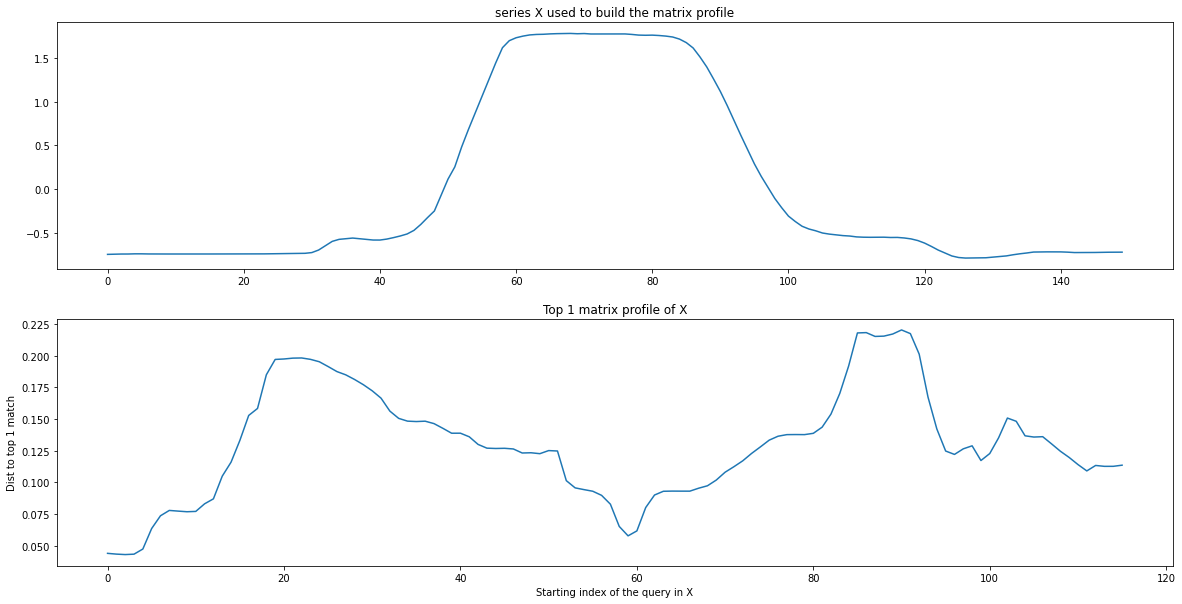

Index of the 20-th query best matches : [[195  26]]


In [11]:
from aeon.similarity_search import SeriesSearch

query_length = 35
estimator = SeriesSearch(distance="euclidean").fit(X_train)  # X_test is a 3D array
mp, ip = estimator.predict(X_test, query_length)  # X_test is a 2D array
plot_matrix_profile(X_test, mp, 0)
print(f"Index of the 20-th query best matches : {ip[20]}")

Notice that we find the same best match for the 20-ith query, which was the query that we used for `QuerySearch` !

`SeriesSearch` returns two lists, `mp` and `ip`, which respectively contain the distances to the best matches of all queries of size `query_length` in `X_test` (the `i-th` query being `X_test[:, i : i + query_length]`) and the indexes of these best matches in `X_train` in the `(ix_case, ix_timepoint)` format, such as `X_train[ix_case, :, ix_timepoint : ix_timepoint + query_length]` will be the matching subsquence.

Most of the options (`k`, `threshold`, `inverse_distance`, etc.) from `QuerySearch` are also available for `SeriesSearch`.